In [156]:
import xarray
import numpy as np
import pandas
import h5py
import datetime
from ulmo.utils import image_utils
from ulmo.plotting import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.feature as cfeature
import os
import matplotlib.ticker as mticker
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import random

In [157]:
# check extraction tables

table_2012 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2012.parquet')
table_2013 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2013.parquet')
table_2014 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2014.parquet')
table_2015 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2015.parquet')
table_2016 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2016.parquet')
table_2017 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2017.parquet')
table_2018 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2018.parquet')
table_2019 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2019.parquet')
table_2020 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2020.parquet')

table_all = pandas.concat([table_2012, table_2013, table_2014, table_2015,
                        table_2016, table_2017, table_2018, table_2019, table_2020])
table_all.reset_index(drop=True, inplace=True)

In [158]:
table_all = table_all.dropna(subset=['LL']) # now we have the matching L2 and L3S w/o days that were skipped

In [159]:
# hypothesis 1: L3S smoothed out fields, this would result in lower DT and high LL
# BUT did it smooth it in a good way (reduce clouds) or did it remove features
# ways to test: in areas that we know should be clear, visually look for temp changes

# mediterranean

med = table_all[
    (table_all['lon'] >= 5) & (table_all['lat'] <= 40) &
    (table_all['lat'] >= 30) & (table_all['lat'] <= 40)
]

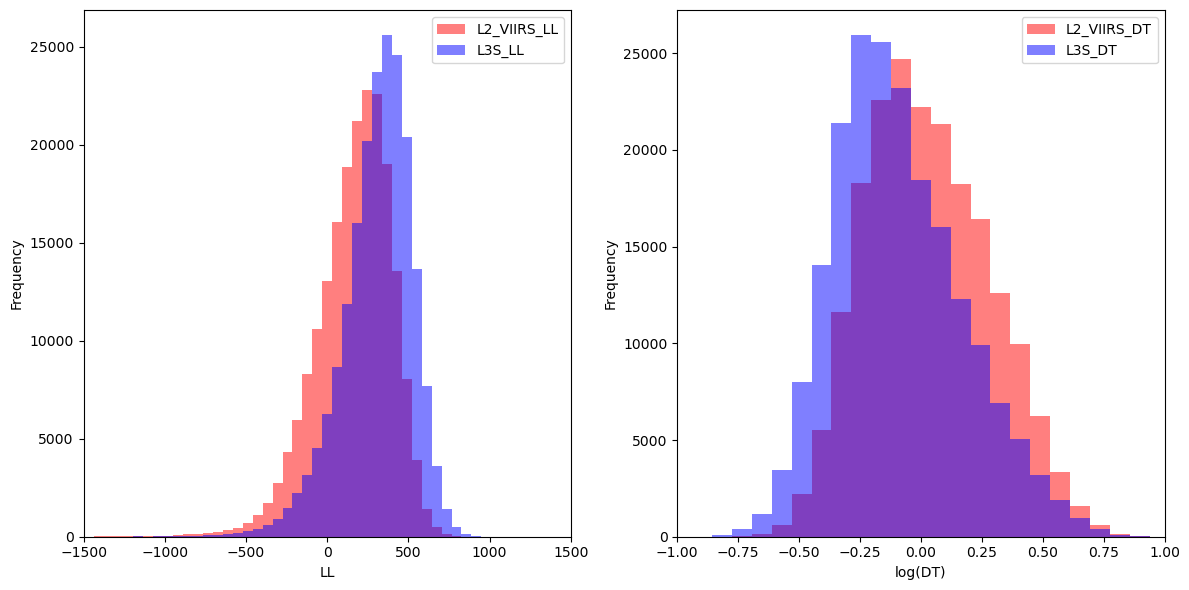

In [160]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
bin_edges = np.linspace(-1500, 1500, 50)
plt.hist(med['VIIRS_LL'], bins=bin_edges, alpha=0.5, label='L2_VIIRS_LL', color='red')
plt.hist(med['LL'], bins=bin_edges, alpha=0.5, label = 'L3S_LL', color = 'blue')
plt.xlabel('LL')
plt.ylabel('Frequency')
plt.xlim(-1500, 1500)
plt.legend()

plt.subplot(1, 2, 2)
bin_edges = np.linspace(-2,2, 50)
plt.hist(np.log10(med['VIIRS_DT']), bins=bin_edges, alpha=0.5, label='L2_VIIRS_DT', color='red')
plt.hist(np.log10(med['DT']), bins=bin_edges, alpha=0.5, label='L3S_DT', color='blue')
plt.xlabel('log(DT)')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.legend()

plt.tight_layout()
plt.show()
# so even in this area that should be really clear to begin with, the L3S data is still increasing LL and decreasing DT

In [161]:
middle_atlantic = table_all[
    (table_all['lon'] >= -45) & (table_all['lon'] <= -25) &
    (table_all['lat'] >= 30) & (table_all['lat'] <= 40)
]

In [162]:
middle_atlantic.loc[:,'VIIRS_clear_fraction'] = 1 - middle_atlantic.loc[:,'VIIRS_clear_fraction']
diff = middle_atlantic.loc[:,'clear_fraction'] - middle_atlantic.loc[:,'VIIRS_clear_fraction']
middle_atlantic.loc[:,'clear_frac_diff'] = diff

med.loc[:,'VIIRS_clear_fraction'] = 1 - med.loc[:,'VIIRS_clear_fraction']
diff = med.loc[:,'clear_fraction'] - med.loc[:,'VIIRS_clear_fraction']
med.loc[:,'clear_frac_diff'] = diff

/var/folders/_r/zbkcbh452sgfkpxvpxh952x80000gv/T/ipykernel_37170/1978808342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  middle_atlantic.loc[:,'clear_frac_diff'] = diff
/var/folders/_r/zbkcbh452sgfkpxvpxh952x80000gv/T/ipykernel_37170/1978808342.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  med.loc[:,'clear_frac_diff'] = diff


/Users/rachelstumpf/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/rachelstumpf/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


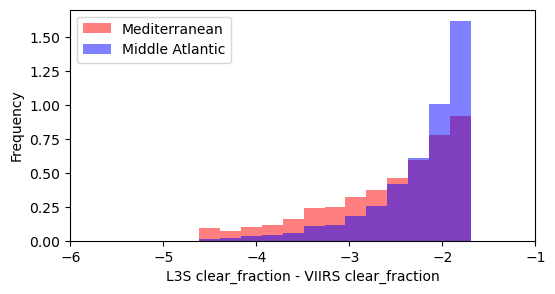

In [163]:
plt.figure(figsize=(6, 3))

bin_edges = np.linspace(-10, 1, 50)
plt.hist(np.log10(med['clear_frac_diff']), bins=bin_edges, alpha=0.5, label='Mediterranean', color='red', density = True)
plt.hist(np.log10(middle_atlantic['clear_frac_diff']), bins=bin_edges, alpha=0.5, label = 'Middle Atlantic', color = 'blue', density = True)
plt.xlabel('L3S clear_fraction - VIIRS clear_fraction')
plt.ylabel('Frequency')
plt.xlim(-6, -1)
plt.legend()

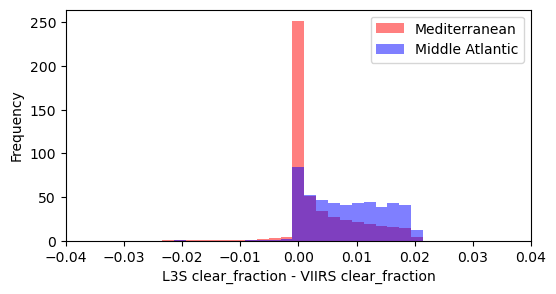

In [164]:
plt.figure(figsize=(6, 3))

bin_edges = np.linspace(-0.05, 0.05, 50)
plt.hist(med['clear_frac_diff'], bins=bin_edges, alpha=0.5, label='Mediterranean', color='red', density = True)
plt.hist(middle_atlantic['clear_frac_diff'], bins=bin_edges, alpha=0.5, label = 'Middle Atlantic', color = 'blue', density = True)
plt.xlabel('L3S clear_fraction - VIIRS clear_fraction')
plt.ylabel('Frequency')
plt.xlim(-0.04, 0.04)
plt.legend()

# clear fractions are usually positive (L3S is more clear)
# Mediterranean is more likely to have exactly the same clear fraction for VIIRS and L3S (likely 1, is completely clear)
# I guess this doesn't tell us about clouds, look at that visually

In [165]:
med_similarDT = med[
    (med['DT'] >= -0.2) & (med['DT'] <= 0.2)
]

In [166]:
random_rows_indices = random.sample(range(len(med_similarDT)), 10)
random_rows = med_similarDT.iloc[random_rows_indices]

In [167]:
def show_image(img: np.ndarray, cm=None, cbar: bool = True, flipud=True,
               vmnx=(None, None), show=False, set_aspect=None, clbl=None,
               ax=None, title=None):
    if cm is None:
        _, cm = plotting.load_palette()
    ax = sns.heatmap(np.flipud(img), xticklabels=[],
                     vmin=vmnx[0], vmax=vmnx[1], ax=ax,
                     yticklabels=[], cmap=cm, cbar=cbar,
                     cbar_kws={'label': clbl})  # 'fontsize': 20})
    if title is not None:
        ax.set_title(title)

    if show:
        plt.show()
    if set_aspect is not None:
        ax.set_aspect(set_aspect)
    return ax

In [187]:
def plot_cutout_set(data):
    length = len(data)
    fig, axes = plt.subplots(len(data), 2, figsize=(10, 2.5*length))

    for i, (_, row) in enumerate(data.iterrows()):
        pp_file = row['VIIRS_pp_file']
        pp_idx = row['VIIRS_pp_idx']
        viirs_datetime = row['VIIRS_datetime']

        viirs_year = viirs_datetime.year
        local_file = f"/Users/rachelstumpf/Desktop/VIIRS/VIIRS_{viirs_year}_95clear_192x192_preproc_viirs_std.h5"
        matching_row = pandas.DataFrame({'pp_file': [pp_file], 'pp_idx': [pp_idx]})
        viirs = image_utils.grab_image(matching_row, local_file=local_file)
        viirs = viirs[0, ...]
    
        pp_file = row['pp_file']
        pp_idx = row['pp_idx']
        local_file = f"/Users/rachelstumpf/Desktop/PreProc/L3S_VIIRS144_{viirs_year}_preproc.h5"
        matching_row = pandas.DataFrame({'pp_file': [pp_file], 'pp_idx': [pp_idx]})
        l3s = image_utils.grab_image(matching_row, local_file=local_file)
        l3s = l3s[0, ...]

        viirs_min = np.min(viirs)
        viirs_max = np.max(viirs)
        l3s_min = np.min(l3s)
        l3s_max = np.max(l3s)

        vmnx = (min(viirs_min, l3s_min), max(viirs_max, l3s_max))

        show_image(viirs, ax=axes[i, 0], title=f'VIIRS - Row {i+1}', vmnx=vmnx)
        show_image(l3s, ax=axes[i, 1], title=f'L3S - Row {i+1}', vmnx=vmnx)

    plt.tight_layout()

    plt.show()

In [285]:
def show_image2(img, cm=None, cbar=True, flipud=True, vmnx=(None, None), vmin=None, vmax=None, show=False, set_aspect=None, clbl=None, ax=None, title=None):
    if cm is None:
        _, cm = plotting.load_palette()
    #
    if flipud:
        img = np.flipud(img)

    ax = sns.heatmap(img, xticklabels=[], vmin=vmin, vmax=vmax, ax=ax, yticklabels=[], cmap=cm, cbar=cbar, cbar_kws={'label': clbl})
    # Set the title
    if title is not None:
        ax.set_title(title)

    if show:
        plt.show()
    if set_aspect is not None:
        ax.set_aspect(set_aspect)
    #
    return ax

def plot_cutout_set2(data):
    length = len(data)
    fig, axes = plt.subplots(len(data), 2, figsize=(10, 2.5*length))

    for i, (_, row) in enumerate(data.iterrows()):
        pp_file = row['VIIRS_pp_file']
        pp_idx = row['VIIRS_pp_idx']
        viirs_datetime = row['VIIRS_datetime']

        viirs_year = viirs_datetime.year
        local_file = f"/Users/rachelstumpf/Desktop/VIIRS/VIIRS_{viirs_year}_95clear_192x192_preproc_viirs_std.h5"
        matching_row = pandas.DataFrame({'pp_file': [pp_file], 'pp_idx': [pp_idx]})
        viirs = image_utils.grab_image(matching_row, local_file=local_file)
        viirs = viirs[0, ...]
    
        pp_file = row['pp_file']
        pp_idx = row['pp_idx']
        local_file = f"/Users/rachelstumpf/Desktop/PreProc/L3S_VIIRS144_{viirs_year}_preproc.h5"
        matching_row = pandas.DataFrame({'pp_file': [pp_file], 'pp_idx': [pp_idx]})
        l3s = image_utils.grab_image(matching_row, local_file=local_file)
        l3s = l3s[0, ...]

        viirs_min = np.min(viirs)
        viirs_max = np.max(viirs)
        l3s_min = np.min(l3s)
        l3s_max = np.max(l3s)

        vmnx = (min(viirs_min, l3s_min), max(viirs_max, l3s_max))
        vmin, vmax = -1, 1

        # Get pp_idx and VIIRS_datetime for title and caption
        pp_idx = row['pp_idx']
        viirs_pp_idx = row['VIIRS_pp_idx']
        viirs_datetime = row['VIIRS_datetime']

        # Create the title and caption for VIIRS image
        viirs_title = f'VIIRS: DT={row["VIIRS_DT"]:.2f} LL={row["VIIRS_LL"]:.2f}'
        viirs_caption = f'VIIRS_pp_idx: {viirs_pp_idx}'

        # Create the title and caption for L3S image
        l3s_title = f'L3S: DT={row["DT"]:.2f} LL={row["LL"]:.2f}'
        l3s_caption = f'pp_idx: {pp_idx}\nVIIRS_datetime: {viirs_datetime}'

        show_image2(viirs, ax=axes[i, 0], title=viirs_title, vmnx=vmnx, vmin=vmin, vmax=vmax)
        axes[i, 0].text(0.5, -0.15, viirs_caption, ha='center', va='center', transform=axes[i, 0].transAxes, fontsize=8)

        show_image2(l3s, ax=axes[i, 1], title=l3s_title, vmnx=vmnx, vmin=vmin, vmax=vmax)
        axes[i, 1].text(0.5, -0.15, l3s_caption, ha='center', va='center', transform=axes[i, 1].transAxes, fontsize=8)

    plt.tight_layout()

    plt.show()

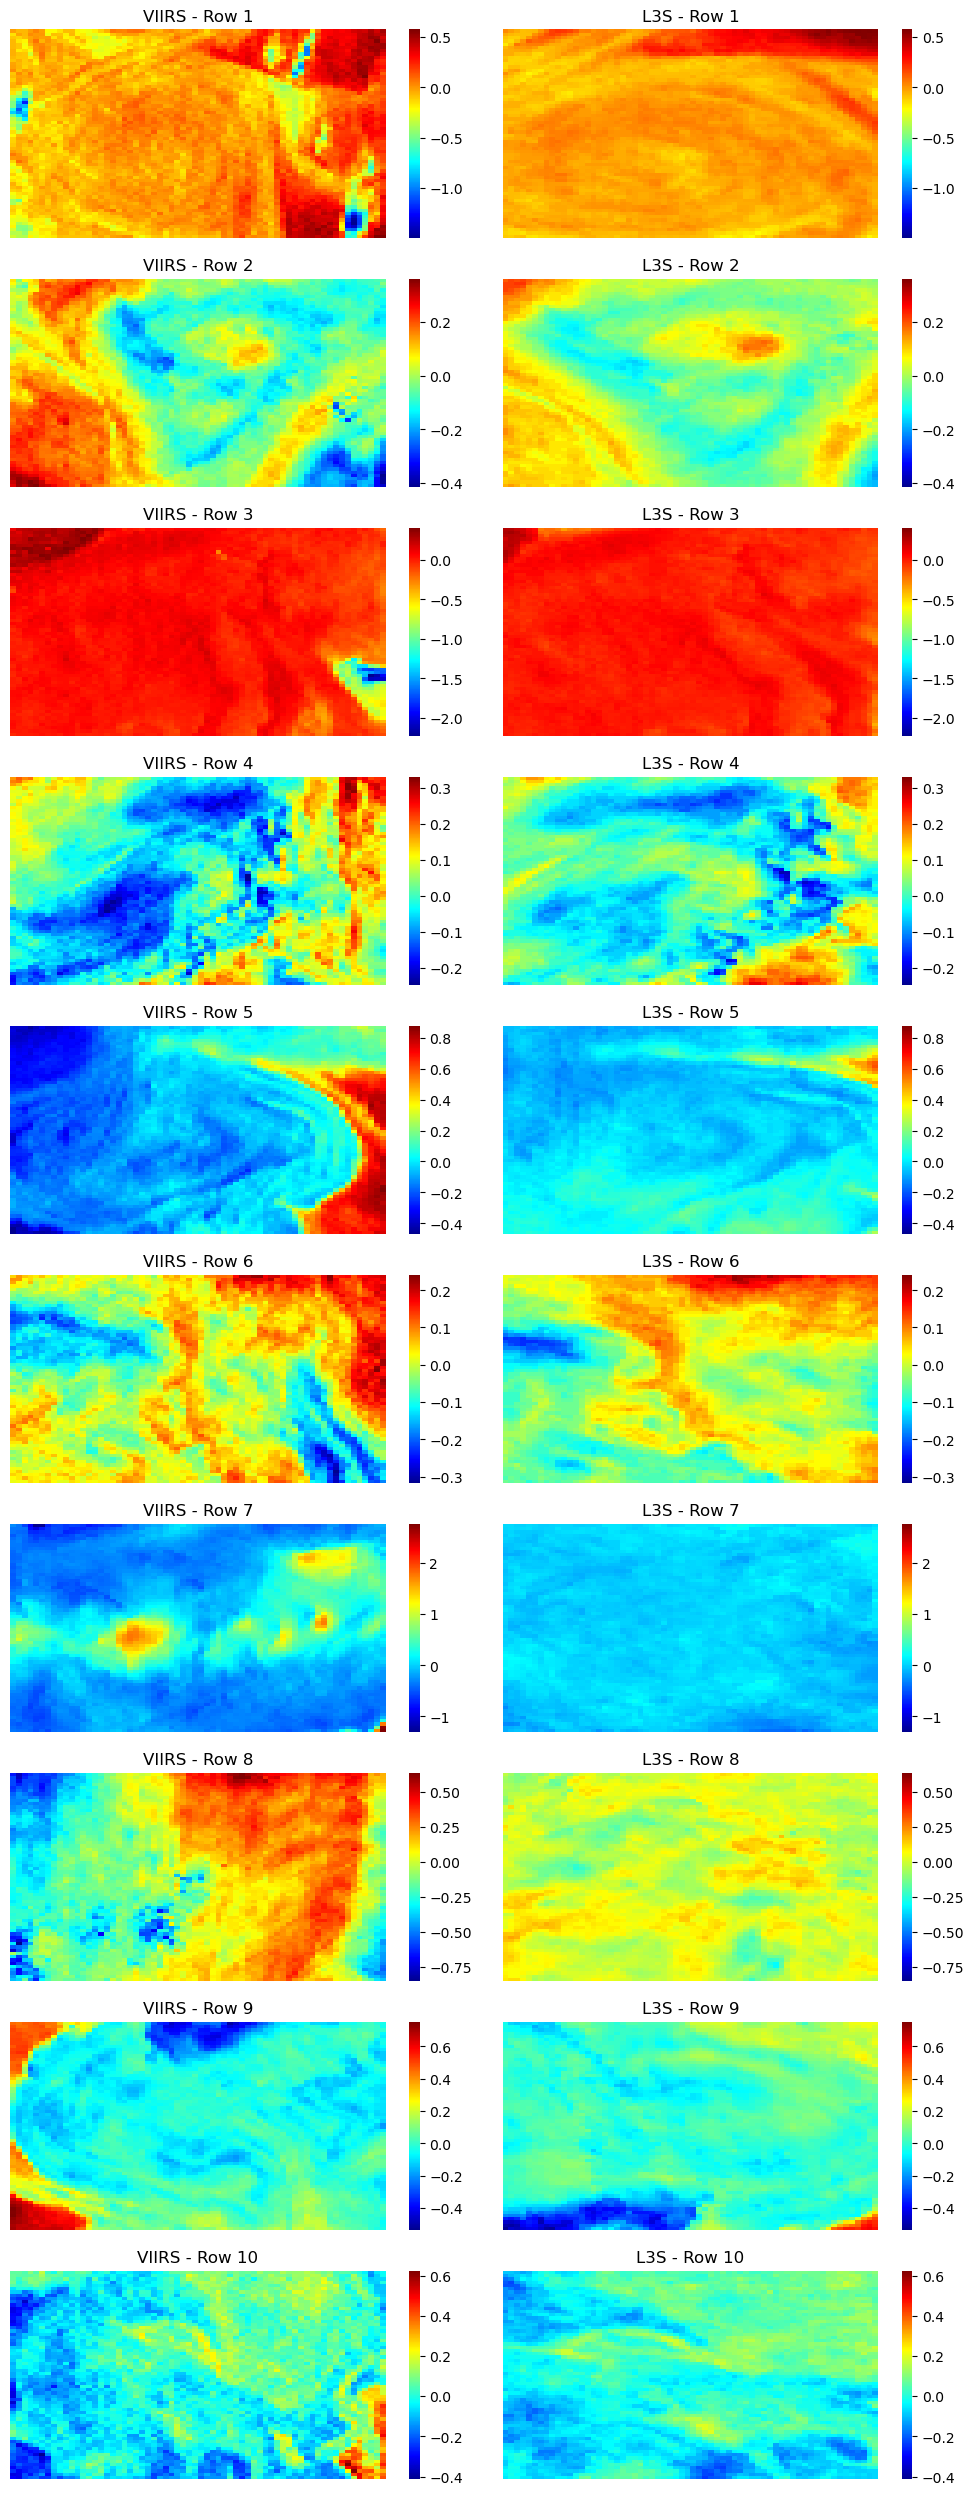

In [265]:
plot_cutout_set(random_rows)

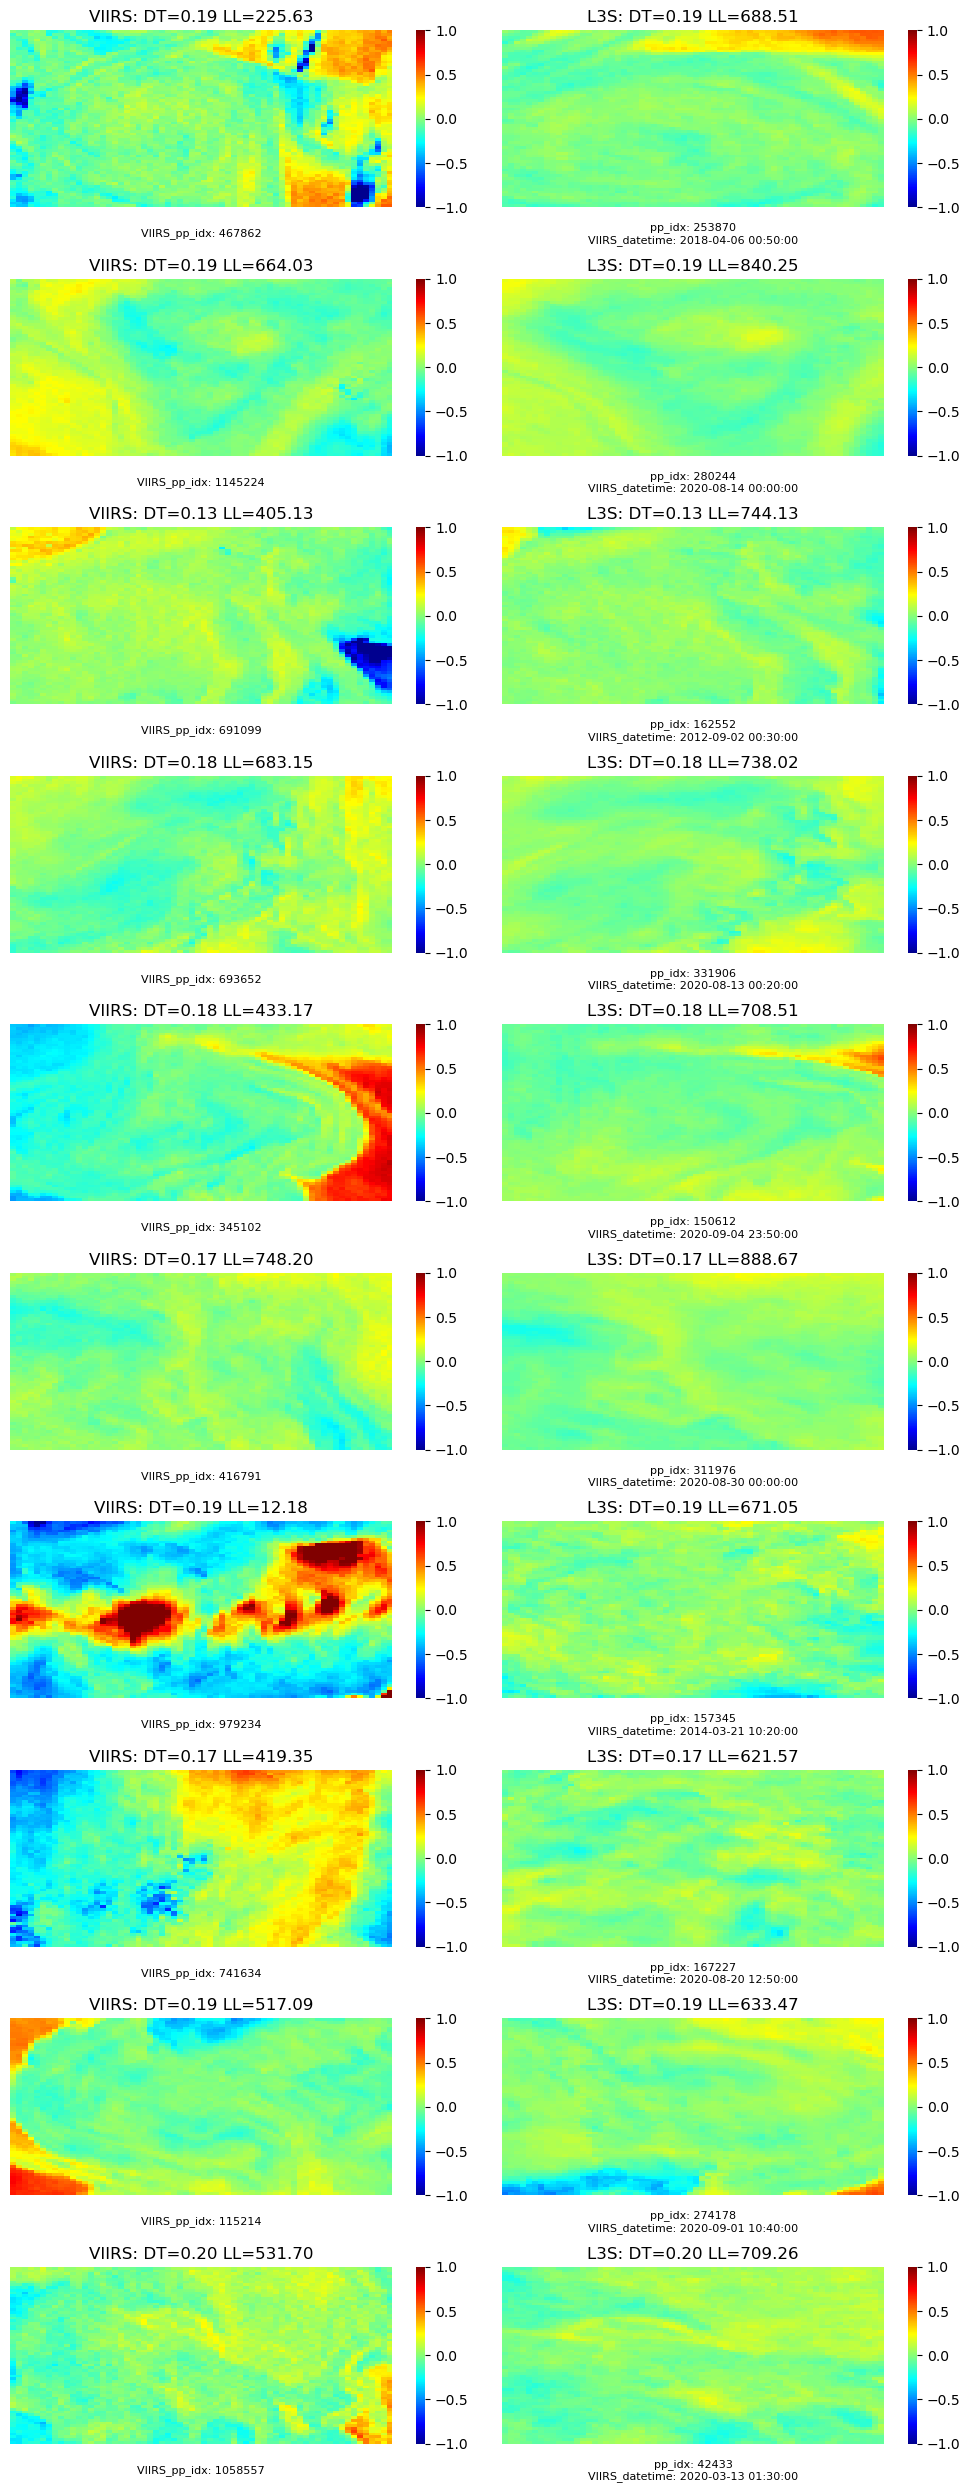

In [282]:
plot_cutout_set2(random_rows)

In [ ]:
# hypothesis 2: L2 is already contaminated with clouds
# L3S did well at reducing this then
# ways to test: 

In [171]:
table_all.loc[:,'diff_DT'] = table_all.loc[:,"VIIRS_DT"] - table_all.loc[:,'DT']
table_all.loc[:,'diff_LL'] = table_all.loc[:,"VIIRS_LL"] - table_all.loc[:,'LL']

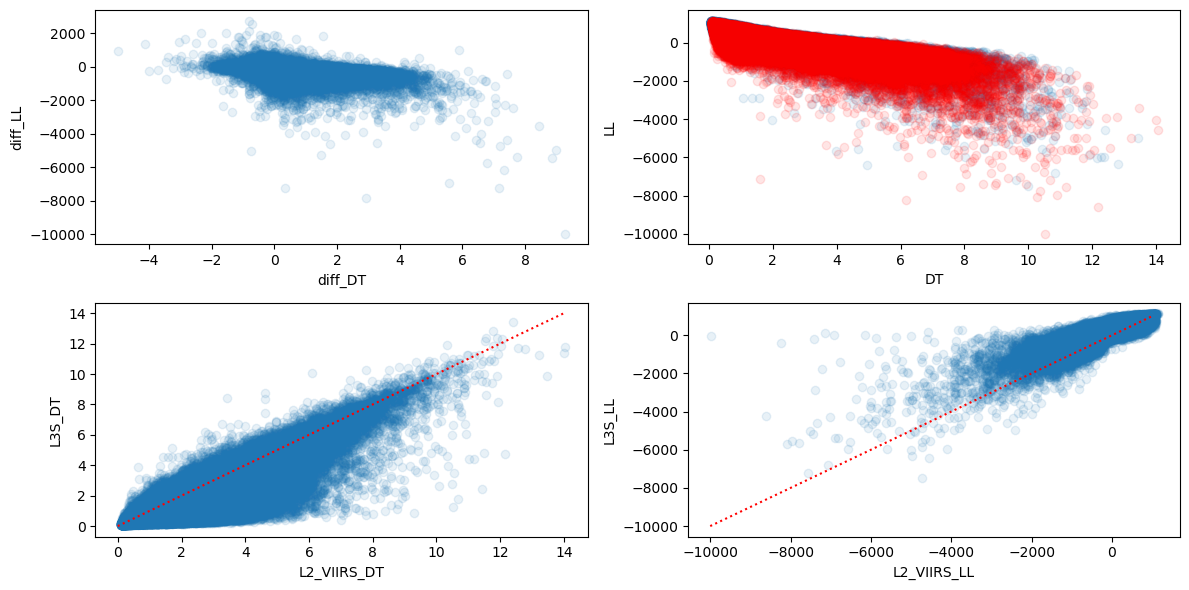

In [172]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.scatter(table_all['diff_DT'], table_all['diff_LL'], alpha = 0.1) # x,y
plt.xlabel('diff_DT')
plt.ylabel('diff_LL')

plt.subplot(2, 2, 2)
plt.scatter(table_all['DT'], table_all['LL'], alpha = 0.1) # x,y
plt.scatter(table_all['VIIRS_DT'], table_all['VIIRS_LL'], alpha = 0.1, color = 'red') 
plt.xlabel('DT')
plt.ylabel('LL')

plt.subplot(2, 2, 3)
plt.scatter(table_all['VIIRS_DT'], table_all['DT'], alpha = 0.1) # x,y
plt.plot([0, 14], [0, 14], color='red', linestyle='dotted')
plt.xlabel('L2_VIIRS_DT')
plt.ylabel('L3S_DT')

plt.subplot(2, 2, 4)
plt.scatter(table_all['VIIRS_LL'], table_all['LL'], alpha = 0.1) # x,y
plt.plot([-10000, 1000], [-10000, 1000], color='red', linestyle='dotted')
plt.xlabel('L2_VIIRS_LL')
plt.ylabel('L3S_LL')

plt.tight_layout()
plt.show()

In [173]:
blacksea = table_all[
    (table_all['lat'] >= 43) & (table_all['lat'] <= 44) &
    (table_all['lon'] >= 33) & (table_all['lon'] <= 34)
]

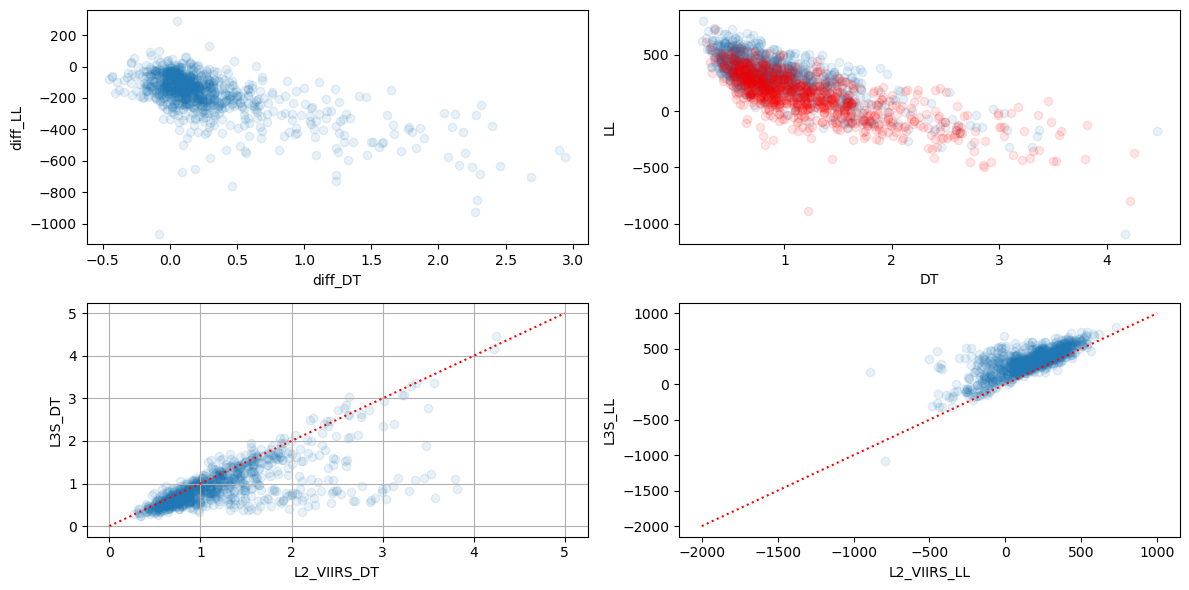

In [174]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.scatter(blacksea['diff_DT'], blacksea['diff_LL'], alpha = 0.1) # x,y
plt.xlabel('diff_DT')
plt.ylabel('diff_LL')

plt.subplot(2, 2, 2)
plt.scatter(blacksea['DT'], blacksea['LL'], alpha = 0.1) # x,y
plt.scatter(blacksea['VIIRS_DT'], blacksea['VIIRS_LL'], alpha = 0.1, color = 'red') 
plt.xlabel('DT')
plt.ylabel('LL')

plt.subplot(2, 2, 3)
plt.scatter(blacksea['VIIRS_DT'], blacksea['DT'], alpha = 0.1) # x,y
plt.plot([0, 5], [0, 5], color='red', linestyle='dotted')
plt.grid(True)
#plt.xlim(6, 12)
plt.xlabel('L2_VIIRS_DT')
plt.ylabel('L3S_DT')

plt.subplot(2, 2, 4)
plt.scatter(blacksea['VIIRS_LL'], blacksea['LL'], alpha = 0.1) # x,y
plt.plot([-2000, 1000], [-2000, 1000], color='red', linestyle='dotted')
plt.xlabel('L2_VIIRS_LL')
plt.ylabel('L3S_LL')

plt.tight_layout()
plt.show()

In [248]:
blacksea.loc[:,'local_timedelta'] = pandas.to_timedelta(blacksea.loc[:,'lon'] / 15, unit='H')
blacksea.loc[:,'local_suntime'] = blacksea.loc[:,'VIIRS_datetime'] + blacksea.loc[:,'local_timedelta']
normalized_date = blacksea.loc[:,'local_suntime'].dt.normalize()
time_component_timedelta = pandas.to_timedelta(blacksea.loc[:,'local_suntime'].dt.hour, unit='h') + pandas.to_timedelta(blacksea['local_suntime'].dt.minute, unit='m') + pandas.to_timedelta(table_all.loc[:,'local_suntime'].dt.second, unit='s')

blacksea.loc[:,'L2_local_suntime'] = normalized_date + time_component_timedelta
blacksea['L2_local_suntime_hours'] = blacksea['L2_local_suntime'].dt.hour + blacksea['L2_local_suntime'].dt.minute / 60 + blacksea['L2_local_suntime'].dt.second / 3600

/var/folders/_r/zbkcbh452sgfkpxvpxh952x80000gv/T/ipykernel_37170/2193756681.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blacksea['L2_local_suntime_hours'] = blacksea['L2_local_suntime'].dt.hour + blacksea['L2_local_suntime'].dt.minute / 60 + blacksea['L2_local_suntime'].dt.second / 3600


In [249]:
nighttime_start = 22.0
nighttime_end = 6.0

nighttime_cutouts = blacksea[
    (blacksea['L2_local_suntime_hours'] >= nighttime_start) |
    (blacksea['L2_local_suntime_hours'] <= nighttime_end)
]

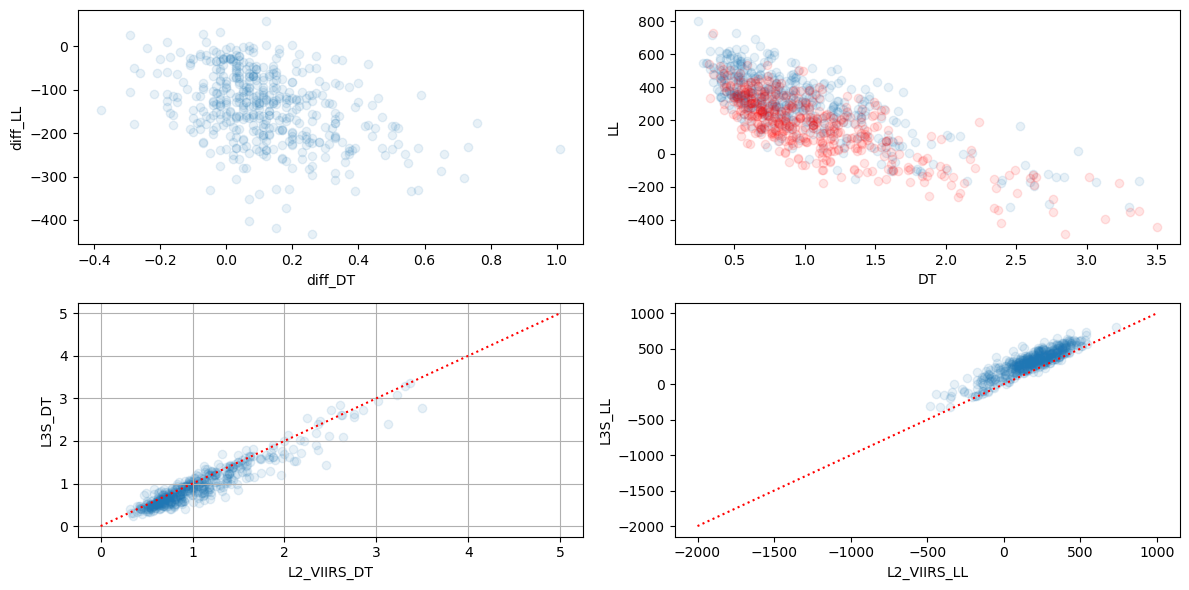

In [250]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.scatter(nighttime_cutouts['diff_DT'], nighttime_cutouts['diff_LL'], alpha = 0.1) # x,y
plt.xlabel('diff_DT')
plt.ylabel('diff_LL')

plt.subplot(2, 2, 2)
plt.scatter(nighttime_cutouts['DT'], nighttime_cutouts['LL'], alpha = 0.1) # x,y
plt.scatter(nighttime_cutouts['VIIRS_DT'], nighttime_cutouts['VIIRS_LL'], alpha = 0.1, color = 'red') 
plt.xlabel('DT')
plt.ylabel('LL')

plt.subplot(2, 2, 3)
plt.scatter(nighttime_cutouts['VIIRS_DT'], nighttime_cutouts['DT'], alpha = 0.1) # x,y
plt.plot([0, 5], [0, 5], color='red', linestyle='dotted')
plt.grid(True)
#plt.xlim(6, 12)
plt.xlabel('L2_VIIRS_DT')
plt.ylabel('L3S_DT')

plt.subplot(2, 2, 4)
plt.scatter(nighttime_cutouts['VIIRS_LL'], nighttime_cutouts['LL'], alpha = 0.1) # x,y
plt.plot([-2000, 1000], [-2000, 1000], color='red', linestyle='dotted')
plt.xlabel('L2_VIIRS_LL')
plt.ylabel('L3S_LL')

plt.tight_layout()
plt.show()

In [261]:
nighttime_cutouts_5 = nighttime_cutouts.head(5)

In [263]:
nighttime_cutouts_5[['DT', 'VIIRS_DT']]

,DT,VIIRS_DT
49088,0.929993,0.959991
50417,1.120026,1.089996
50425,0.679993,0.679993
52601,0.900024,1.100006
63709,0.479980,0.429993


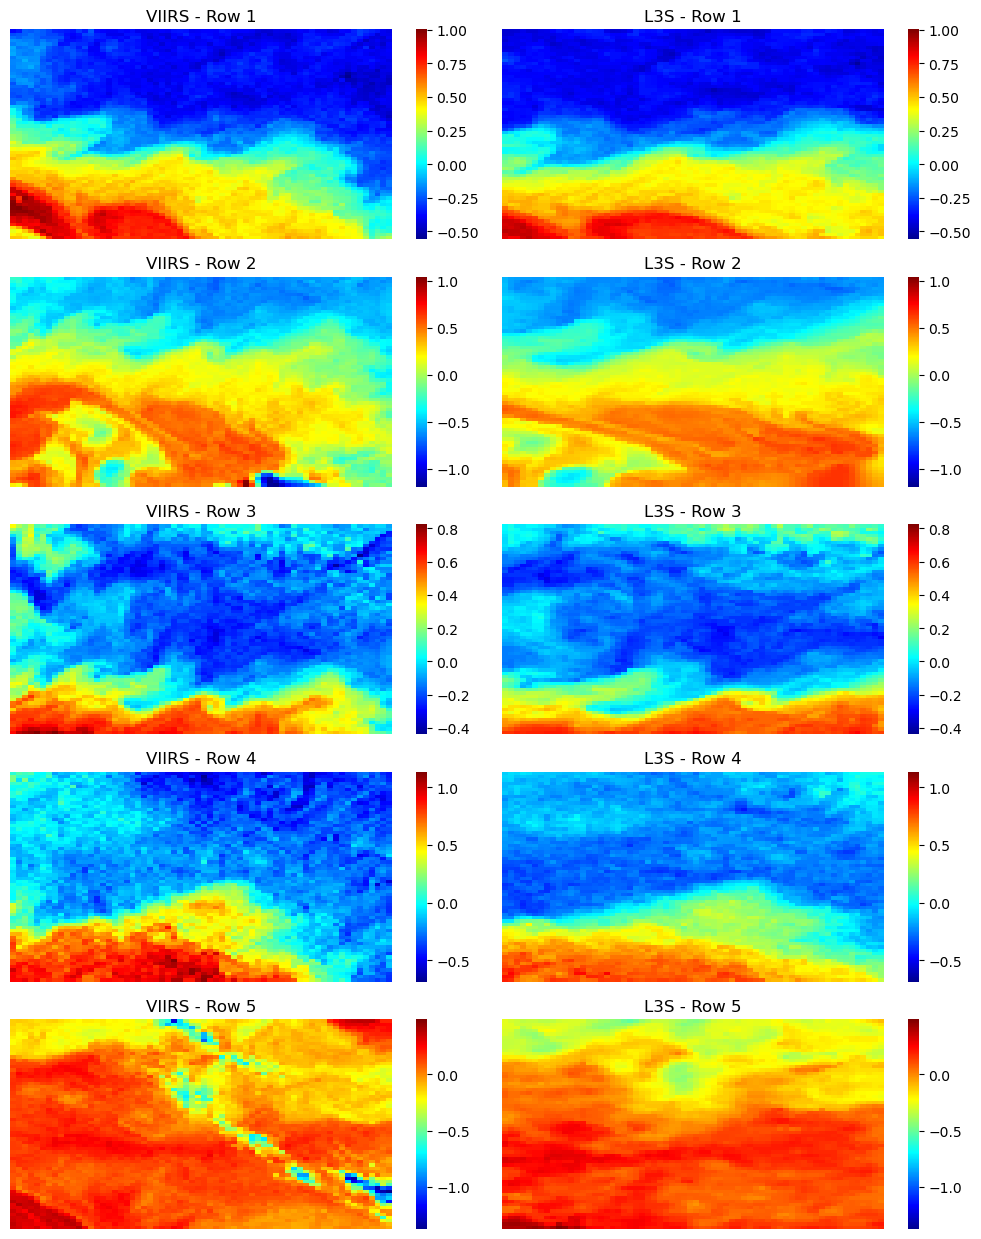

In [262]:
plot_cutout_set(nighttime_cutouts_5) # add title w log likelihood & DT, row /column number, all same range

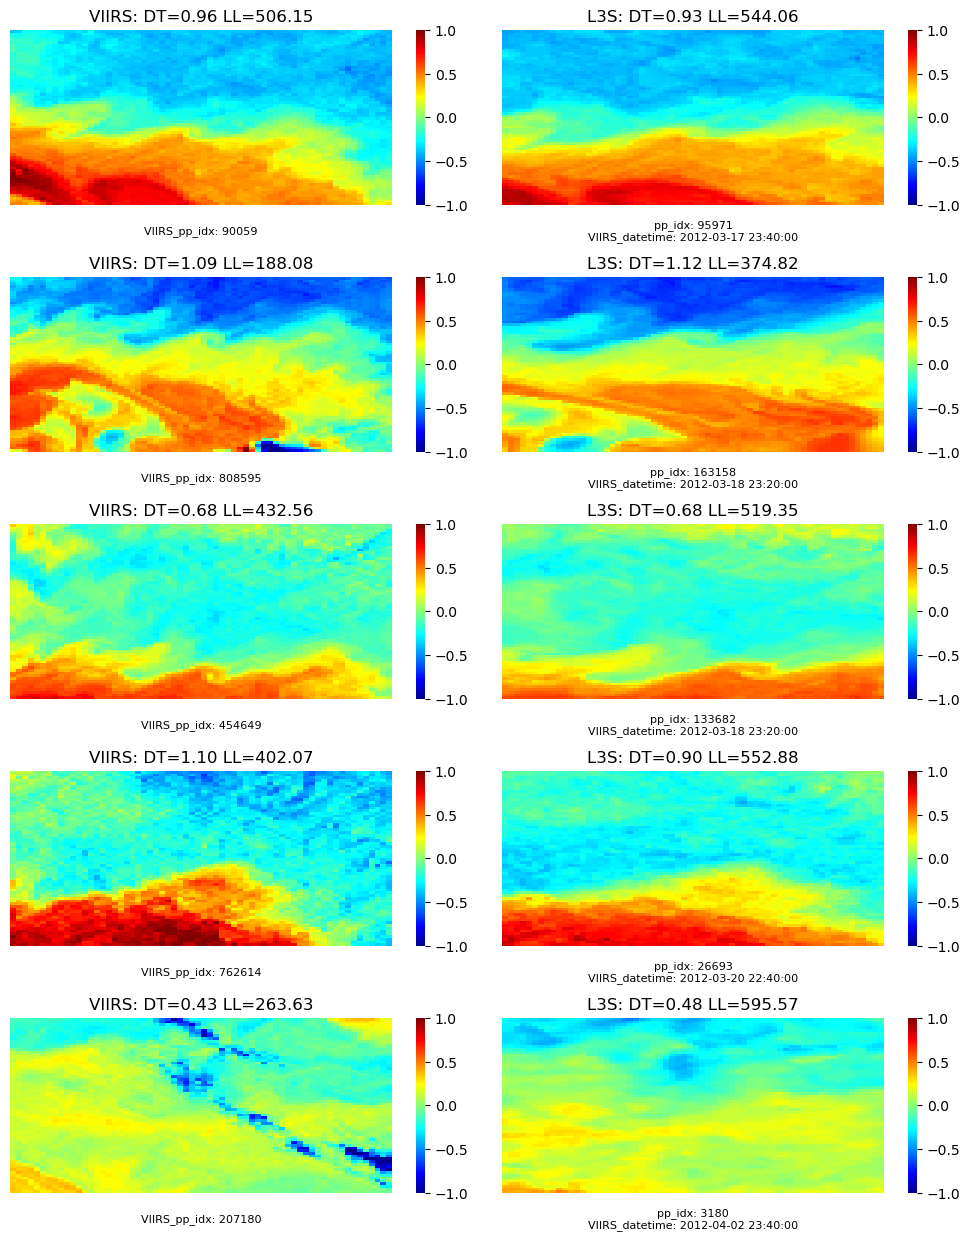

In [286]:
plot_cutout_set2(nighttime_cutouts_5)

In [356]:
row = nighttime_cutouts_5.iloc[4]

pp_file = row['VIIRS_pp_file']
pp_idx = row['VIIRS_pp_idx']
viirs_year = row['VIIRS_datetime'].year

local_file = f"/Users/rachelstumpf/Desktop/VIIRS/VIIRS_{viirs_year}_95clear_192x192_preproc_viirs_std.h5"
matching_row = pandas.DataFrame({'pp_file': [pp_file], 'pp_idx': [pp_idx]})
viirs = image_utils.grab_image(matching_row, local_file=local_file)
#viirs = viirs[0, ...]
    
pp_file = row['pp_file']
pp_idx = row['pp_idx']
local_file = f"/Users/rachelstumpf/Desktop/PreProc/L3S_VIIRS144_{viirs_year}_preproc.h5"
matching_row = pandas.DataFrame({'pp_file': [pp_file], 'pp_idx': [pp_idx]})
l3s = image_utils.grab_image(matching_row, local_file=local_file)
#l3s = l3s[0, ...]

In [357]:
l3s

array([[[ 0.40821695,  0.40821695,  0.3982072 , ...,  0.14820719,
          0.1681962 ,  0.18821573],
        [ 0.4181962 ,  0.42820597,  0.42820597, ...,  0.15821695,
          0.19819498,  0.20820475],
        [ 0.3682084 ,  0.38819742,  0.38819742, ...,  0.10819864,
          0.12821817,  0.15821695],
        ...,
        [-0.2817855 , -0.2817855 , -0.27180624, ..., -0.29179525,
         -0.2517867 , -0.21177816],
        [-0.27180624, -0.2817855 , -0.31178427, ..., -0.2517867 ,
         -0.20179892, -0.17180014],
        [-0.27180624, -0.30180502, -0.31178427, ..., -0.16179037,
         -0.13179159, -0.10179281]]], dtype=float32)

In [358]:
l3s = l3s.reshape((4096,))
viirs = viirs.reshape((4096,))

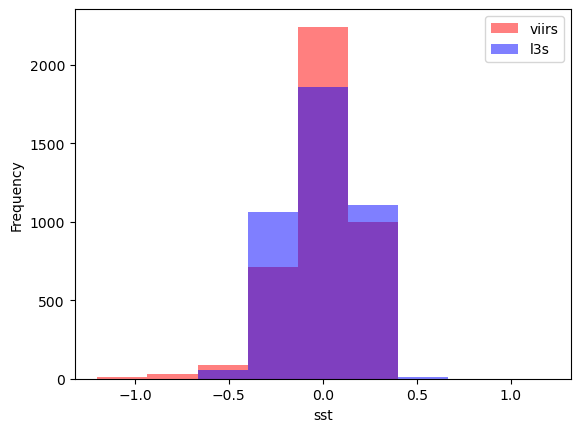

In [359]:
bin_edges = np.linspace(-1.2,1.2,10)
plt.hist(viirs, bins=bin_edges, alpha=0.5, label='viirs', color='red', density = False)
plt.hist(l3s, bins=bin_edges, alpha=0.5, label='l3s', color='blue', density = False)

plt.xlabel('sst')
plt.ylabel('Frequency')
plt.legend()
plt.show()
# sum 100 of these together to see if it tightens
# SOMETHING WRONG W HISTOGRAM

In [253]:
coefficients = np.polyfit(nighttime_cutouts['VIIRS_DT'], nighttime_cutouts['DT'], deg=1)

m, b = coefficients

# Create a linear function based on the fitted coefficients
def linear_fit(x):
    return m * x + b

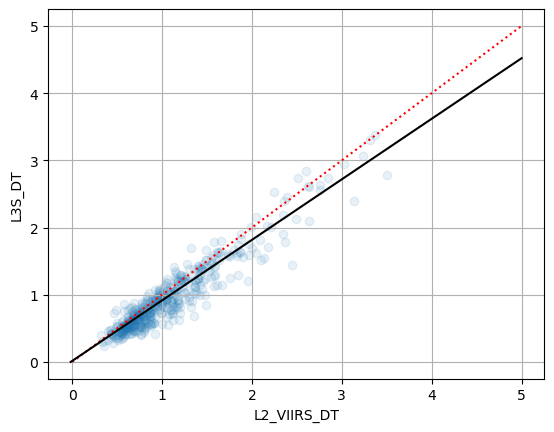

In [256]:
plt.scatter(nighttime_cutouts['VIIRS_DT'], nighttime_cutouts['DT'], alpha = 0.1) # x,y
plt.plot([0, 5], [0, 5], color='red', linestyle='dotted')
plt.plot([b,5],[0,m*5+b], color='black')
plt.grid(True)
#plt.xlim(6, 12)
plt.xlabel('L2_VIIRS_DT')
plt.ylabel('L3S_DT')
plt.show()

In [254]:
linear_fit(coefficients)

array([ 0.80622779, -0.03235946])

In [175]:
new_blacksea = blacksea[
    (blacksea['VIIRS_DT'] >= 1.5) & (blacksea['VIIRS_DT'] <= 2)  &
    (blacksea['DT'] >= 0.5) & (blacksea['DT'] <= 0.6)
]

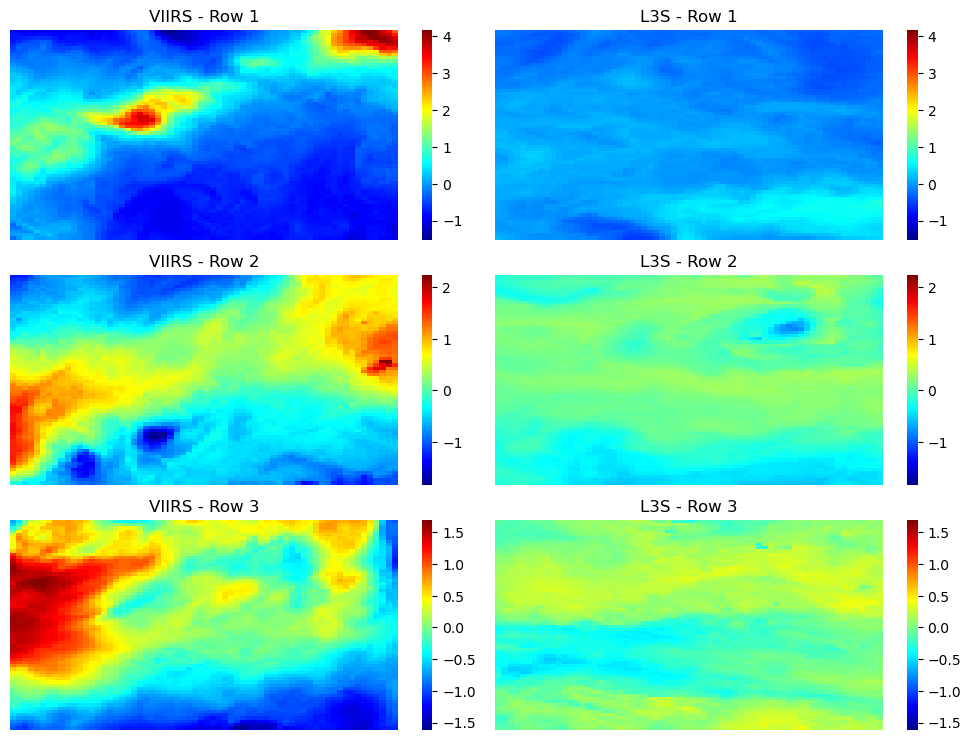

In [189]:
plot_cutout_set(new_blacksea)

In [273]:
table_all.loc[:,'local_timedelta'] = pandas.to_timedelta(table_all.loc[:,'lon'] / 15, unit='H')
table_all.loc[:,'local_suntime'] = table_all.loc[:,'VIIRS_datetime'] + table_all.loc[:,'local_timedelta']
normalized_date = table_all.loc[:,'local_suntime'].dt.normalize()
time_component_timedelta = pandas.to_timedelta(table_all.loc[:,'local_suntime'].dt.hour, unit='h') + pandas.to_timedelta(table_all['local_suntime'].dt.minute, unit='m') + pandas.to_timedelta(table_all.loc[:,'local_suntime'].dt.second, unit='s')

table_all.loc[:,'L2_local_suntime'] = normalized_date + time_component_timedelta

In [192]:
table_all[['VIIRS_datetime', 'L2_local_suntime', 'lon']]

,VIIRS_datetime,L2_local_suntime,lon
0,2012-02-01 00:10:00,2012-01-31 12:22:25,-176.892460
1,2012-02-01 00:10:00,2012-01-31 12:24:46,-176.305300
2,2012-02-01 00:10:00,2012-01-31 12:29:19,-175.170240
3,2012-02-01 00:10:00,2012-01-31 12:26:47,-175.801420
4,2012-02-01 00:10:00,2012-01-31 12:23:59,-176.500980
...,...,...,...
2932447,2020-12-31 22:50:00,2020-12-31 13:18:21,-142.909970
2932448,2020-12-31 22:50:00,2020-12-31 12:53:53,-149.027340
2932449,2020-12-31 22:50:00,2020-12-31 12:53:21,-149.160080
2932450,2020-12-31 23:30:00,2021-01-01 02:09:20,39.833706


In [193]:
# make a scatterplot where y is L2_local_suntime and x is diff in DT

table_all.columns

Index(['VIIRS_row', 'VIIRS_col', 'VIIRS_UID', 'VIIRS_LL', 'VIIRS_pp_file',
       'VIIRS_pp_idx', 'VIIRS_T90', 'VIIRS_T10', 'VIIRS_DT', 'VIIRS_pp_type',
       'VIIRS_Tmin', 'VIIRS_Tmax', 'VIIRS_clear_fraction', 'VIIRS_datetime',
       'VIIRS_filename', 'VIIRS_ex_filename', 'VIIRS_lat', 'VIIRS_lon', 'row',
       'col', 'lat', 'lon', 'datetime', 'ex_filename', 'filename', 'pp_file',
       'pp_root', 'field_size', 'pp_idx', 'pp_type', 'mean_temperature',
       'Tmin', 'Tmax', 'T90', 'T10', 'clear_fraction', 'DT', 'LL', 'diff_DT',
       'diff_LL', 'local_timedelta', 'local_suntime', 'L2_local_suntime'],
      dtype='object')

In [210]:
table_all.loc[:,'L2_local_suntime_time'] = table_all.loc[:,'L2_local_suntime'].dt.time

In [203]:
table_all['L2_local_suntime_seconds'] = table_all['L2_local_suntime'].dt.hour * 3600 + table_all['L2_local_suntime'].dt.minute * 60 + table_all['L2_local_suntime'].dt.second

In [205]:
table_all['L2_local_suntime_hours'] = table_all['L2_local_suntime'].dt.hour + table_all['L2_local_suntime'].dt.minute / 60 + table_all['L2_local_suntime'].dt.second / 3600

# Convert 'diff_DT' to total hours
#table_all['diff_DT_hours'] = table_all['diff_DT'].dt.total_seconds() / 3600

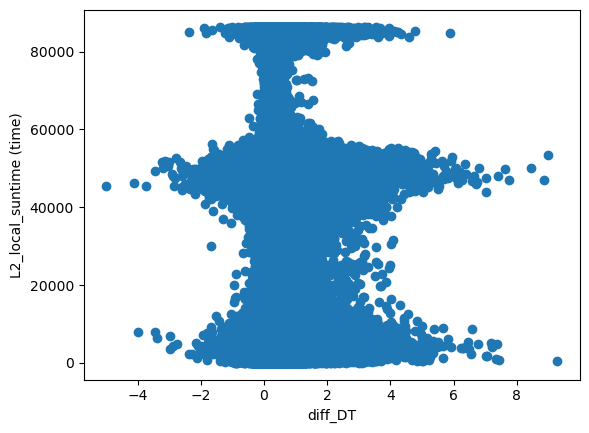

In [201]:
plt.scatter(table_all['diff_DT'], table_all['L2_local_suntime_seconds'])

plt.xlabel('diff_DT')
plt.ylabel('L2_local_suntime (time)')

plt.show()

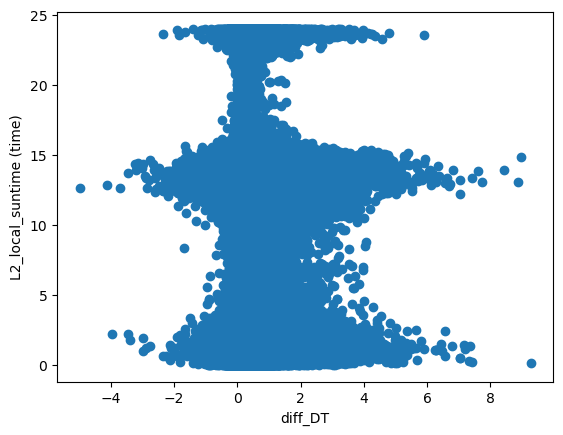

In [206]:
plt.scatter(table_all['diff_DT'], table_all['L2_local_suntime_hours'])

plt.xlabel('diff_DT')
plt.ylabel('L2_local_suntime (time)')

plt.show()

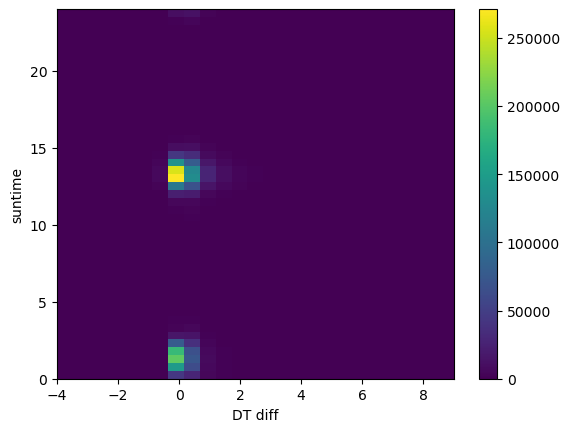

In [222]:
x_bins = np.linspace(-4, 9, 26)  # 26 bins for half-degree increments
y_bins = np.linspace(0, 24, 48)  # 48 bins for half-hour increments

plt.hist2d(table_all['diff_DT'], table_all['L2_local_suntime_hours'], bins=[x_bins, y_bins], cmap='viridis')

plt.xlabel('DT diff')
plt.ylabel('suntime')

plt.colorbar()
plt.show()

X-axis bins (local suntime):
[-4.   -3.48 -2.96 -2.44 -1.92 -1.4  -0.88 -0.36  0.16  0.68  1.2   1.72
  2.24  2.76  3.28  3.8   4.32  4.84  5.36  5.88  6.4   6.92  7.44  7.96
  8.48  9.  ]
Y-axis bins (diff_DT):
[ 0.          0.5106383   1.0212766   1.53191489  2.04255319  2.55319149
  3.06382979  3.57446809  4.08510638  4.59574468  5.10638298  5.61702128
  6.12765957  6.63829787  7.14893617  7.65957447  8.17021277  8.68085106
  9.19148936  9.70212766 10.21276596 10.72340426 11.23404255 11.74468085
 12.25531915 12.76595745 13.27659574 13.78723404 14.29787234 14.80851064
 15.31914894 15.82978723 16.34042553 16.85106383 17.36170213 17.87234043
 18.38297872 18.89361702 19.40425532 19.91489362 20.42553191 20.93617021
 21.44680851 21.95744681 22.46808511 22.9787234  23.4893617  24.        ]
2D Histogram:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 2. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


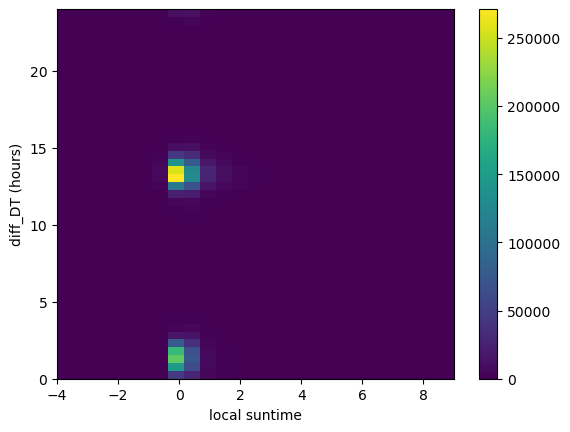

In [224]:
x_bins = np.linspace(-4, 9, 26)
y_bins = np.linspace(0, 24, 48)
hist, x_edges, y_edges = np.histogram2d(table_all['diff_DT'], table_all['L2_local_suntime_hours'], bins=[x_bins, y_bins])

print("X-axis bins (local suntime):")
print(x_edges)
print("Y-axis bins (diff_DT):")
print(y_edges)

print("2D Histogram:")
print(hist)

plt.hist2d(table_all['diff_DT'], table_all['L2_local_suntime_hours'], bins=[x_bins, y_bins], cmap='viridis')

plt.xlabel('local suntime')
plt.ylabel('diff_DT (hours)')

plt.colorbar()
plt.show()

In [228]:
print("2D Histogram:")
for y_index, y_bin in enumerate(y_edges[:-1]):
    for x_index, x_bin in enumerate(x_edges[:-1]):
        count = hist[x_index, y_index]
        print(f"Bin (diff_DT: {x_bin:.2f}, local_suntime: {y_bin:.2f}) - Observations: {count}")


2D Histogram:
Bin (diff_DT: -4.00, local_suntime: 0.00) - Observations: 0.0
Bin (diff_DT: -3.48, local_suntime: 0.00) - Observations: 0.0
Bin (diff_DT: -2.96, local_suntime: 0.00) - Observations: 0.0
Bin (diff_DT: -2.44, local_suntime: 0.00) - Observations: 1.0
Bin (diff_DT: -1.92, local_suntime: 0.00) - Observations: 1.0
Bin (diff_DT: -1.40, local_suntime: 0.00) - Observations: 35.0
Bin (diff_DT: -0.88, local_suntime: 0.00) - Observations: 285.0
Bin (diff_DT: -0.36, local_suntime: 0.00) - Observations: 44440.0
Bin (diff_DT: 0.16, local_suntime: 0.00) - Observations: 28522.0
Bin (diff_DT: 0.68, local_suntime: 0.00) - Observations: 4305.0
Bin (diff_DT: 1.20, local_suntime: 0.00) - Observations: 1087.0
Bin (diff_DT: 1.72, local_suntime: 0.00) - Observations: 378.0
Bin (diff_DT: 2.24, local_suntime: 0.00) - Observations: 154.0
Bin (diff_DT: 2.76, local_suntime: 0.00) - Observations: 52.0
Bin (diff_DT: 3.28, local_suntime: 0.00) - Observations: 33.0
Bin (diff_DT: 3.80, local_suntime: 0.00)

In [ ]:
# 2d matrix with values

In [234]:
observation_matrix = np.empty((len(y_edges) - 1, len(x_edges) - 1), dtype=int)
for y_index in range(len(y_edges) - 1):
    for x_index in range(len(x_edges) - 1):
        observation_matrix[y_index, x_index] = hist[x_index, y_index]

/var/folders/_r/zbkcbh452sgfkpxvpxh952x80000gv/T/ipykernel_37170/1617145754.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(observation_matrix), origin='lower', aspect='auto', cmap='viridis', extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]])


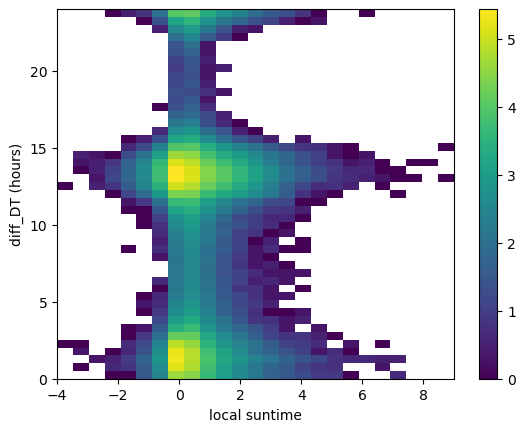

In [239]:
plt.imshow(np.log10(observation_matrix), origin='lower', aspect='auto', cmap='viridis', extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]])

# Set labels for the x and y axes
plt.xlabel('local suntime')
plt.ylabel('diff_DT (hours)')

# Show the colorbar
plt.colorbar()
plt.show()

In [242]:
nighttime_start = 22.0
nighttime_end = 6.0

nighttime_cutouts = table_all[
    (table_all['L2_local_suntime_hours'] >= nighttime_start) |
    (table_all['L2_local_suntime_hours'] <= nighttime_end)
]

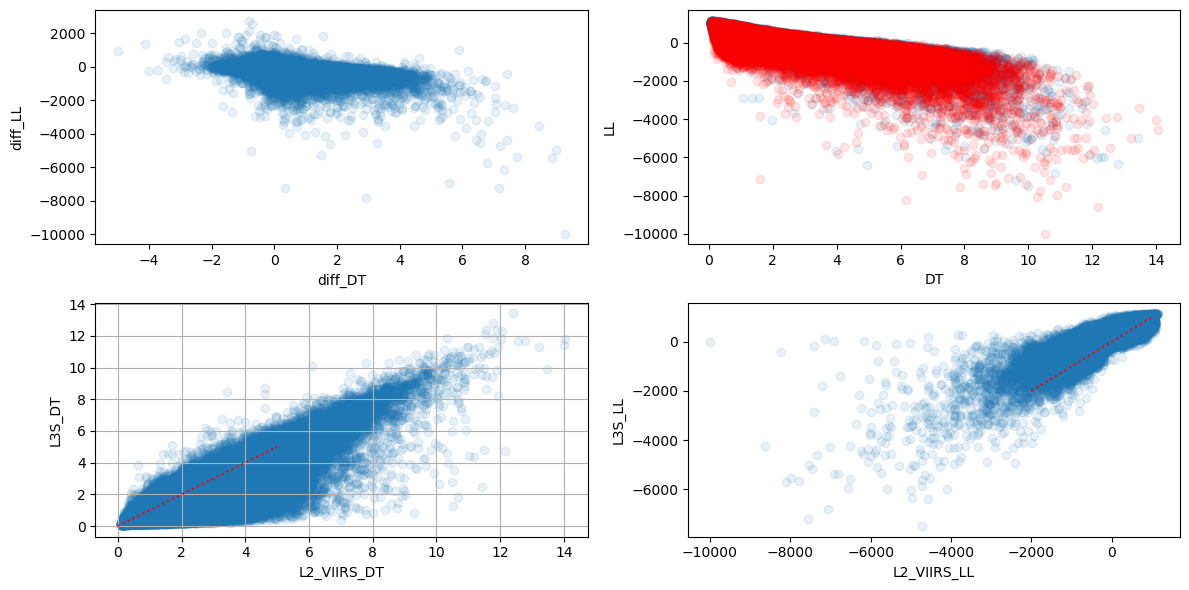

In [243]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.scatter(nighttime_cutouts['diff_DT'], nighttime_cutouts['diff_LL'], alpha = 0.1) # x,y
plt.xlabel('diff_DT')
plt.ylabel('diff_LL')

plt.subplot(2, 2, 2)
plt.scatter(nighttime_cutouts['DT'], nighttime_cutouts['LL'], alpha = 0.1) # x,y
plt.scatter(nighttime_cutouts['VIIRS_DT'], nighttime_cutouts['VIIRS_LL'], alpha = 0.1, color = 'red') 
plt.xlabel('DT')
plt.ylabel('LL')

plt.subplot(2, 2, 3)
plt.scatter(nighttime_cutouts['VIIRS_DT'], nighttime_cutouts['DT'], alpha = 0.1) # x,y
plt.plot([0, 5], [0, 5], color='red', linestyle='dotted')
plt.grid(True)
#plt.xlim(6, 12)
plt.xlabel('L2_VIIRS_DT')
plt.ylabel('L3S_DT')

plt.subplot(2, 2, 4)
plt.scatter(nighttime_cutouts['VIIRS_LL'], nighttime_cutouts['LL'], alpha = 0.1) # x,y
plt.plot([-2000, 1000], [-2000, 1000], color='red', linestyle='dotted')
plt.xlabel('L2_VIIRS_LL')
plt.ylabel('L3S_LL')

plt.tight_layout()
plt.show()